In [4]:
import pandas as pd
import re
from pathlib import Path

PANEL_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")
PRODUCTS = ["MERRA2", "ERA5_025", "GMFD", "JRA_3Q"]   # add more if you have them
CHUNK = 100_000

def make_crosswalk(product: str, panel_dir=PANEL_DIR, chunk=CHUNK) -> Path:
    panel_fn = panel_dir / f"global_mortality_panel_public_{product}.dta"

    # 1) Peek at first chunk to discover columns (and the LR column name for this product)
    it = pd.read_stata(panel_fn, iterator=True, chunksize=chunk, convert_categoricals=False)
    first = next(it)
    cols = first.columns.tolist()

    # product-specific LR column (fallbacks if not exact)
    lr_exact = [c for c in cols
                if re.fullmatch(fr"lr_tavg_{re.escape(product)}_adm1_avg", c, flags=re.IGNORECASE)]
    if lr_exact:
        lr_col = lr_exact[0]
    else:
        candidates = [c for c in cols if re.match(r"^lr_tavg_.*_adm1_avg$", c, flags=re.IGNORECASE)]
        pref = [c for c in candidates if re.search(re.escape(product), c, flags=re.IGNORECASE)]
        if not candidates:
            raise RuntimeError(f"No lr_tavg_*_adm1_avg column found for {product}")
        lr_col = pref[0] if pref else candidates[0]

    gdp_col = "loggdppc_adm1_avg"

    needed = [c for c in ["adm0","adm1","adm1_id","adm2","adm2_id", gdp_col, lr_col] if c in cols]
    if not set(["adm0","adm1_id","adm2_id"]).issubset(needed):
        raise RuntimeError(f"{product}: required ID cols missing in {panel_fn.name}")

    print(f"{product}: using LR column {lr_col!r}; keeping {needed}")

    # 2) Stream only the needed columns and collapse to unique admin combos
    out = []
    it2 = pd.read_stata(panel_fn, iterator=True, chunksize=chunk,
                        convert_categoricals=False, columns=needed)
    for ch in it2:
        out.append(ch.drop_duplicates(["adm0","adm1_id","adm2_id"]))

    crosswalk = (pd.concat(out, ignore_index=True)
                   .drop_duplicates(["adm0","adm1_id","adm2_id"])
                   .sort_values(["adm0","adm1","adm2"])
                   .reset_index(drop=True))

    # 3) Save per-product crosswalk
    out_csv = panel_fn.with_name(f"adm_crosswalk_{product}.csv")
    crosswalk.to_csv(out_csv, index=False)
    print(f"Wrote crosswalk: {out_csv}")
    return out_csv

# ---- run for all products ----
written = []
for prod in PRODUCTS:
    try:
        p = make_crosswalk(prod)
        if p is not None:
            written.append(p)
    except Exception as e:
        print(f"{prod}: {e}")

print("\nDone. Files written:")
for p in written:
    print(" •", p)


MERRA2: using LR column 'lr_tavg_MERRA2_adm1_avg'; keeping ['adm0', 'adm1', 'adm1_id', 'adm2', 'adm2_id', 'loggdppc_adm1_avg', 'lr_tavg_MERRA2_adm1_avg']
Wrote crosswalk: /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_MERRA2.csv
ERA5_025: using LR column 'lr_tavg_ERA5_025_adm1_avg'; keeping ['adm0', 'adm1', 'adm1_id', 'adm2', 'adm2_id', 'loggdppc_adm1_avg', 'lr_tavg_ERA5_025_adm1_avg']
Wrote crosswalk: /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_ERA5_025.csv
GMFD: using LR column 'lr_tavg_GMFD_adm1_avg'; keeping ['adm0', 'adm1', 'adm1_id', 'adm2', 'adm2_id', 'loggdppc_adm1_avg', 'lr_tavg_GMFD_adm1_avg']
Wrote crosswalk: /user/ab5405/summeraliaclimate/code/regressions/prep_panels/adm_crosswalk_GMFD.csv
JRA_3Q: using LR column 'lr_tavg_JRA_3Q_adm1_avg'; keeping ['adm0', 'adm1', 'adm1_id', 'adm2', 'adm2_id', 'loggdppc_adm1_avg', 'lr_tavg_JRA_3Q_adm1_avg']
Wrote crosswalk: /user/ab5405/summeraliaclimate/code/regressions/prep_panels/a

In [7]:
import pandas as pd
import re
from pathlib import Path

PRODUCT = "MERRA2"
XWALK_CSV = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels") / f"adm_crosswalk_{PRODUCT}.csv"

xw = pd.read_csv(XWALK_CSV, dtype=str)  # load as strings
 
def find_adm2(patterns, country=None, df=xw, n=50):
    """
    Search crosswalk for admin-2 rows whose adm2 OR adm1 matches any pattern.
    Optional: restrict to a country name via `country` (matches adm0, case-insensitive).
    Works even if 'iso' column is absent.
    """
    dd = df.copy()
    if country is not None and 'adm0' in dd.columns:
        dd = dd[dd['adm0'].str.contains(country, case=False, na=False)]
    pat = re.compile("|".join(patterns), flags=re.IGNORECASE)

    # ensure the columns exist; if missing, create empty ones so .apply works
    for col in ['adm1','adm2']:
        if col not in dd.columns:
            dd[col] = ""

    mask = dd[['adm2','adm1']].apply(lambda s: s.fillna('').str.contains(pat)).any(axis=1)

    # only select the columns that actually exist
    cols_to_show = [c for c in ['iso','adm0','adm1','adm1_id','adm2','adm2_id'] if c in dd.columns]
    out = dd.loc[mask, cols_to_show].drop_duplicates()
    return out.head(n)

# Examples:
kolkata_hits = find_adm2([r'kolkata', r'calcutta', r'howrah', r'west\s*ben'], country="India")
print("Kolkata/Calcutta candidates:\n", kolkata_hits.to_string(index=False))

mumbai_hits = find_adm2([r'mumbai', r'bombay', r'greater\s*mumbai', r'maharashtra'], country="India")
print("\nMumbai candidates:\n", mumbai_hits.to_string(index=False))


Kolkata/Calcutta candidates:
  adm0        adm1 adm1_id          adm2 adm2_id
india west bengal      14 24 - parganas       8
india west bengal      14       bankura      14
india west bengal      14       birbhum      13
india west bengal      14       burdwan      12
india west bengal      14      calcutta       9
india west bengal      14   cooch behar       3
india west bengal      14    darjeeling       1
india west bengal      14       hooghly      11
india west bengal      14        howrah      10
india west bengal      14    jalpaiguri       2
india west bengal      14         malda       5
india west bengal      14     midnapore      15
india west bengal      14   murshidabad       6
india west bengal      14         nadia       7
india west bengal      14       purulia      16
india west bengal      14 west dinajpur       4

Mumbai candidates:
  adm0        adm1 adm1_id           adm2 adm2_id
india maharashtra      20     ahmadnagar       8
india maharashtra      20          

In [8]:
#the purpose of this function is to get adm2 specific covariates needed to draw the 
#temp curves. 

def covars_for_adm(product, adm1_id, adm2_id,
                   panel_fn=PANEL_FN, chunk=CHUNK,
                   lr_col=LR_COL, gdp_col=GDP_COL, keep_cols=NEEDED):
    #reads the panel, iterates over columns, chunks, and keeps only needed cols. 
    it = pd.read_stata(panel_fn, iterator=True, chunksize=chunk,
                       convert_categoricals=False, columns=keep_cols)
    #for each chunk, filter for rows where the adm2 id match perfectly. Select only the fields of interest
    #associated w this.  
    for ch in it:
        hit = ch.loc[(ch["adm1_id"] == adm1_id) & (ch["adm2_id"] == adm2_id),
                     ["adm0","adm1","adm2","adm1_id","adm2_id", gdp_col, lr_col]]
        if not hit.empty:
            r = hit.iloc[0]
            #for any non-empty row found, take the first row and return a dictionary w the values. Log gdp and 
            #lr temp are adm1 averages, therefore, it doesn't matter if you only pull the first row found
            return {
                "adm0": r["adm0"], "adm1": r["adm1"], "adm2": r["adm2"],
                "adm1_id": r["adm1_id"], "adm2_id": r["adm2_id"],
                "loggdppc": float(r[gdp_col]),
                "lr_tavg":  float(r[lr_col]),
                "product":  product
            }
    raise ValueError(f"({adm1_id}, {adm2_id}) not found in {panel_fn.name}")


NameError: name 'PANEL_FN' is not defined

In [15]:
import pandas as pd
import re
from pathlib import Path

PANEL_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/prep_panels")

def _lr_col_for_product(cols, product: str) -> str:
    """Pick the correct lr_tavg_*_adm1_avg column from a crosswalk."""
    exact = [c for c in cols if re.fullmatch(fr"lr_tavg_{re.escape(product)}_adm1_avg", c, flags=re.I)]
    if exact:
        return exact[0]
    # fallback: any lr_tavg_*_adm1_avg, preferring ones containing the product string
    cands = [c for c in cols if re.match(r"^lr_tavg_.*_adm1_avg$", c, flags=re.I)]
    if not cands:
        raise RuntimeError(f"No lr_tavg_*_adm1_avg column found for {product}")
    pref = [c for c in cands if re.search(re.escape(product), c, flags=re.I)]
    return pref[0] if pref else cands[0]

def covars_for_adm(product: str, adm1_id: str, adm2_id: str, *,
                   panel_dir: Path = PANEL_DIR,
                   gdp_col: str = "loggdppc_adm1_avg",
                   lat: float | None = None,
                   lon: float | None = None) -> dict:
    """
    Look up ADM2 covariates from the per-product crosswalk CSV.
    Optionally attach lat/lon (needed later for KDE).
    """
    xwalk_fn = panel_dir / f"adm_crosswalk_{product}.csv"
    df = pd.read_csv(xwalk_fn, dtype=str)
    cols = df.columns.tolist()

    # get correct LR column name for this product
    lr_col = _lr_col_for_product(cols, product)

    # coerce numerics safely
    for c in [gdp_col, lr_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # make sure IDs compare as strings
    df["adm1_id"] = df["adm1_id"].astype(str)
    df["adm2_id"] = df["adm2_id"].astype(str)

    hit = df.loc[(df["adm1_id"] == str(adm1_id)) & (df["adm2_id"] == str(adm2_id))]
    if hit.empty:
        raise ValueError(f"({adm1_id}, {adm2_id}) not found in {xwalk_fn.name}")

    r = hit.iloc[0]
    out = {
        "adm0":     r.get("adm0"),
        "adm1":     r.get("adm1"),
        "adm2":     r.get("adm2"),
        "adm1_id":  r["adm1_id"],
        "adm2_id":  r["adm2_id"],
        "loggdppc": float(r[gdp_col]) if pd.notna(r[gdp_col]) else None,
        "lr_tavg":  float(r[lr_col])  if pd.notna(r[lr_col])  else None,
        "product":  product,
        # keep a human-friendly name if present
        "name":     r.get("adm2") or r.get("adm1_id"),
    }
    if lat is not None: out["lat"] = float(lat)
    if lon is not None: out["lon"] = float(lon)
    return out


In [16]:
# add ~city-center lat/lon so KDE works
geneva   = covars_for_adm("ERA5_025", adm1_id="CH0",  adm2_id="CH01", lat=46.2044, lon=6.1432)
london   = covars_for_adm("ERA5_025", adm1_id="UKI",  adm2_id="UKI4",  lat=51.5074, lon=-0.1278)
kolkata  = covars_for_adm("ERA5_025", adm1_id="14",   adm2_id="9",     lat=22.5726, lon=88.3639)

cov_dict = {"LONDON": london, "GENEVA": geneva, "KOLKATA": kolkata}


In [17]:
xw.loc[xw['adm0'].str.contains("India", case=False, na=False)
       & xw['adm1'].str.contains("west", case=False, na=False)
       & xw['adm2'].str.contains("calcutta", case=False, na=False)]


,adm0,adm1,adm1_id,adm2,adm2_id,loggdppc_adm1_avg,lr_tavg_MERRA2_adm1_avg
8881,india,west bengal,14,calcutta,9,7.122819423675537,25.43310451965927


In [18]:
geneva_cov = covars_for_adm(PRODUCT, adm1_id ="CH0", adm2_id = "CH01")   # Geneva Kanton code you found
london_cov = covars_for_adm(PRODUCT, adm1_id ="UKI", adm2_id = "UKI4")
calcutta_cov = covars_for_adm(PRODUCT, adm1_id="14", adm2_id="9")  # Inner London – West, from your list
print(geneva_cov)
print(london_cov)
print(calcutta_cov)

cov_dict = {
    "GENEVA":   geneva_cov,
    "LONDON":   london_cov,
    "CALCUTTA": calcutta_cov
}

# add approximate city centers (deg). W = negative, E = positive.
cov_dict["GENEVA"].update(  {"lat": 46.2044, "lon":  6.1432})
cov_dict["LONDON"].update(  {"lat": 51.5072, "lon": -0.1276})
cov_dict["CALCUTTA"].update({"lat": 22.5726, "lon": 88.3639})  # Kolkata

{'adm0': 'Switzerland', 'adm1': nan, 'adm2': nan, 'adm1_id': 'CH0', 'adm2_id': 'CH01', 'loggdppc': 10.755590438842772, 'lr_tavg': 4.856013176643811, 'product': 'MERRA2', 'name': nan}
{'adm0': 'United Kingdom', 'adm1': nan, 'adm2': nan, 'adm1_id': 'UKI', 'adm2_id': 'UKI4', 'loggdppc': 10.86367893218994, 'lr_tavg': 9.940411184558464, 'product': 'MERRA2', 'name': nan}
{'adm0': 'india', 'adm1': 'west bengal', 'adm2': 'calcutta', 'adm1_id': '14', 'adm2_id': '9', 'loggdppc': 7.122819423675537, 'lr_tavg': 25.43310451965927, 'product': 'MERRA2', 'name': 'calcutta'}


In [19]:
#This chunk takes the betas/gammas from the csvv for the age-interacted regressions and plugs in the covariates found in the previous chunk to produce the specific age-group mortality curves 
#in London, Geneva, and Calcutta. 

import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#Reads the entire csvv as text 
def read_gamma_from_csvv(path: Path):
    txt = Path(path).read_text()
    #allows . to match newlines, and makes case insensitive 
    m = re.search(r"\bgamma\s*\n(.*?)\n\s*gammavcv\b", txt, flags=re.S|re.I)
    if not m:
        raise ValueError(f"Could not find gamma block in: {path}")
    #extract all the floats in the block, should be 36 blocks in total
    nums = re.findall(r"[-+]?(?:\d+\.?\d*|\.\d+)(?:[Ee][-+]?\d+)?", m.group(1))
    vals = np.array(list(map(float, nums)))
    if vals.size != 36:
        raise ValueError(f"Expected 36 gamma values, found {vals.size} in {path}")
    #reshapes to a 3x4x3 set, with 3 age groups, 4 poly terms for each, and 3 covariates for each
    return vals.reshape(3, 4, 3)

#takes the polynomials for each age group in a city and the covariates. Computes the effective 
#coeff for the age and cite. 
def coeffs_for_city(gamma_age_poly_covar, lr_tavg, loggdppc):
    eff = (gamma_age_poly_covar[:, 0] +
           gamma_age_poly_covar[:, 1] * lr_tavg +
           gamma_age_poly_covar[:, 2] * loggdppc)
    return {"b1": eff[0], "b2": eff[1], "b3": eff[2], "b4": eff[3]}

#creates a quartic w no constant since they are normalized at the optimum later 
def quartic_no_const(T, b):
    return b["b1"]*T + b["b2"]*T**2 + b["b3"]*T**3 + b["b4"]*T**4

#sets the derivative of the poly function and finds its real roots.
def find_Tstar_analytic(b, Tmin=-15.0, Tmax=45.0):
    # derivative: 4 b4 T^3 + 3 b3 T^2 + 2 b2 T + b1 = 0
    roots = np.roots([4*b["b4"], 3*b["b3"], 2*b["b2"], b["b1"]])
    roots = roots[np.isreal(roots)].real
    cand = [t for t in roots if Tmin <= t <= Tmax] + [Tmin, Tmax]
    vals = [quartic_no_const(t, b) for t in cand]
    return float(cand[int(np.argmin(vals))])

#returns the function minus the minimum 
def curve_min_slice(Tgrid, b, Tmin_slice=0.0, Tmax_slice=30.0):
    """
    Return y(T) - min_{T in [Tmin_slice, Tmax_slice]} y(T).
    Falls back to global min if the slice has no grid points.
    """
    y = quartic_no_const(Tgrid, b)
    mask = (Tgrid >= Tmin_slice) & (Tgrid <= Tmax_slice)
    baseline = y[mask].min() if mask.any() else y.min()
    return y - baseline

#plots each curve 
AGE_LABELS = ["Young", "Middle", "Old"]

def plot_age_curves_for_product_no_kde(product: str,
                                cov_dict: dict,
                                csvv_dir=Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv"),
                                spec="spec2",
                                tmin=-15, tmax=45):
    """
    product: "MERRA2" | "ERA5_025" | "GMFD" | "JRA_3Q"
    cov_dict: {"LONDON": {adm0,..., loggdppc, lr_tavg, ...}, ...}
    """
    csvv_path = csvv_dir / f"agespec_interaction_response_{spec}_{product}.csvv"
    gamma = read_gamma_from_csvv(csvv_path)

    #takes the keys of the covaraiate dictionary w city names and ids, determines how many cities
    #to plot
    cities = list(cov_dict.keys())
    n = len(cities)
    T = np.linspace(tmin, tmax, 800)

    #creates a row of n subplots, one column per city, makes all the subplots use the same y-axis
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharey=False)

    if n == 1:
        axes = [axes]

    #loop over each city
    for ax, key in zip(axes, cities):
        city = cov_dict[key]
        #title the panel by the city names
        name = city.get("name") or f"{city.get('adm2_id','')} ({city.get('adm1_id','')})"
        #for each age group in the city, select the 4x3 slice for that group, build the poly coeff
        #using that city's covariates, then use the norm cuve function to set optimum T at zero
        for a in range(3):
            b = coeffs_for_city(gamma[a, :, :],
                                lr_tavg=city["lr_tavg"],
                                loggdppc=city["loggdppc"])
        
            y = curve_min_slice(T, b, Tmin_slice=10.0, Tmax_slice=25.0)
            ax.plot(T, y, lw=2.2, label=f"{AGE_LABELS[a]}")

        #dash line at 0 = each curve's "optimal" mortality baseline. 
        ax.axhline(0, ls="--", color="k", lw=1)
        ax.set_title(name)
        ax.set_xlabel("Temperature [°C]")
        ax.grid(False)

    axes[0].set_ylabel("Effect on mortality rate\nrelative to location-specific optimum [per 100,000]")
    axes[-1].legend(frameon=True, fontsize=9, loc="upper left")
    fig.suptitle(f"Spec 2 ({product}): age-specific curves", y=1.02)
    plt.tight_layout()
    plt.show()


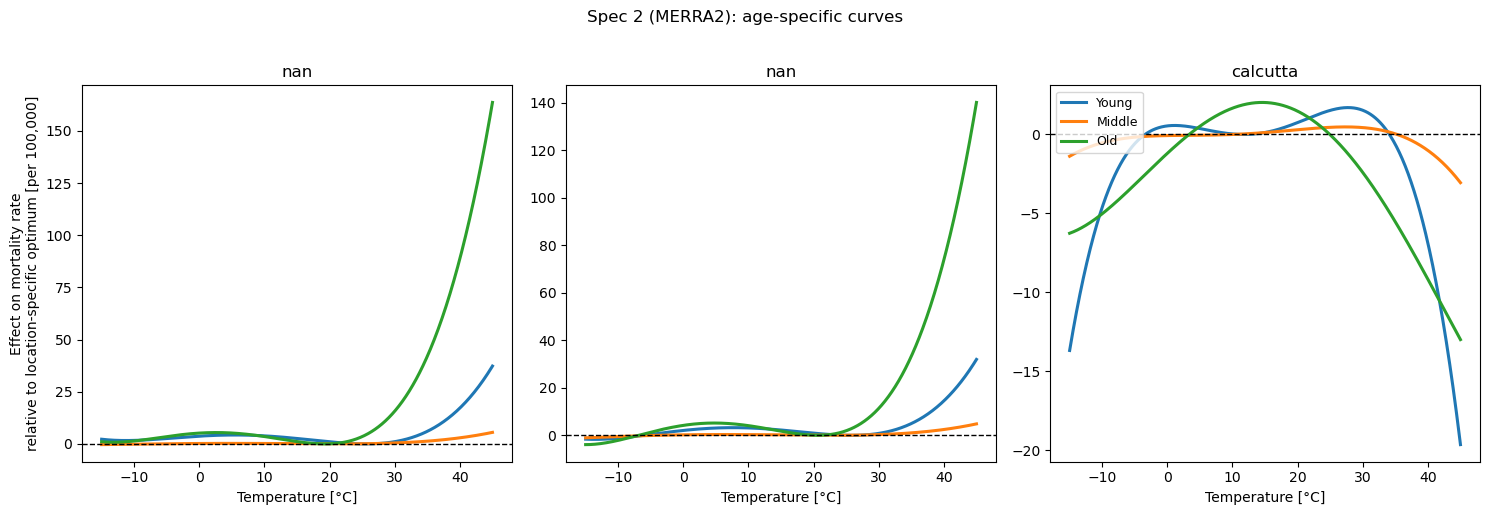

In [20]:
# Call for one product
plot_age_curves_for_product_no_kde("MERRA2", cov_dict)

In [ ]:
debug_city("london",   gamma, T, cov_dict)
debug_city("geneva",   gamma, T, cov_dict)
debug_city("calcutta", gamma, T, cov_dict) 


In [163]:
def debug_city(name, gamma, T, cov_dict):
    # case-insensitive lookup
    try:
        key = next(k for k in cov_dict if k.lower() == name.lower())
    except StopIteration:
        raise KeyError(f"{name!r} not found. Available: {list(cov_dict.keys())}")

    city = cov_dict[key]
    print(f"\n== {key} ==")
    print("covariates:", {k: city[k] for k in ("lr_tavg","loggdppc")})
    for a,label in enumerate(["Young","Middle","Old"]):
        b = coeffs_for_city(gamma[a,:,:],
                            lr_tavg=city["lr_tavg"],
                            loggdppc=city["loggdppc"])
        parts35 = {"b1*T": b["b1"]*35, "b2*T^2": b["b2"]*35**2,
                   "b3*T^3": b["b3"]*35**3, "b4*T^4": b["b4"]*35**4}
        parts45 = {"b1*T": b["b1"]*45, "b2*T^2": b["b2"]*45**2,
                   "b3*T^3": b["b3"]*45**3, "b4*T^4": b["b4"]*45**4}
        print(f"{label} b={b}")
        print(f"  f(35) parts {parts35}  total={sum(parts35.values()):.3f}")
        print(f"  f(45) parts {parts45}  total={sum(parts45.values()):.3f}")


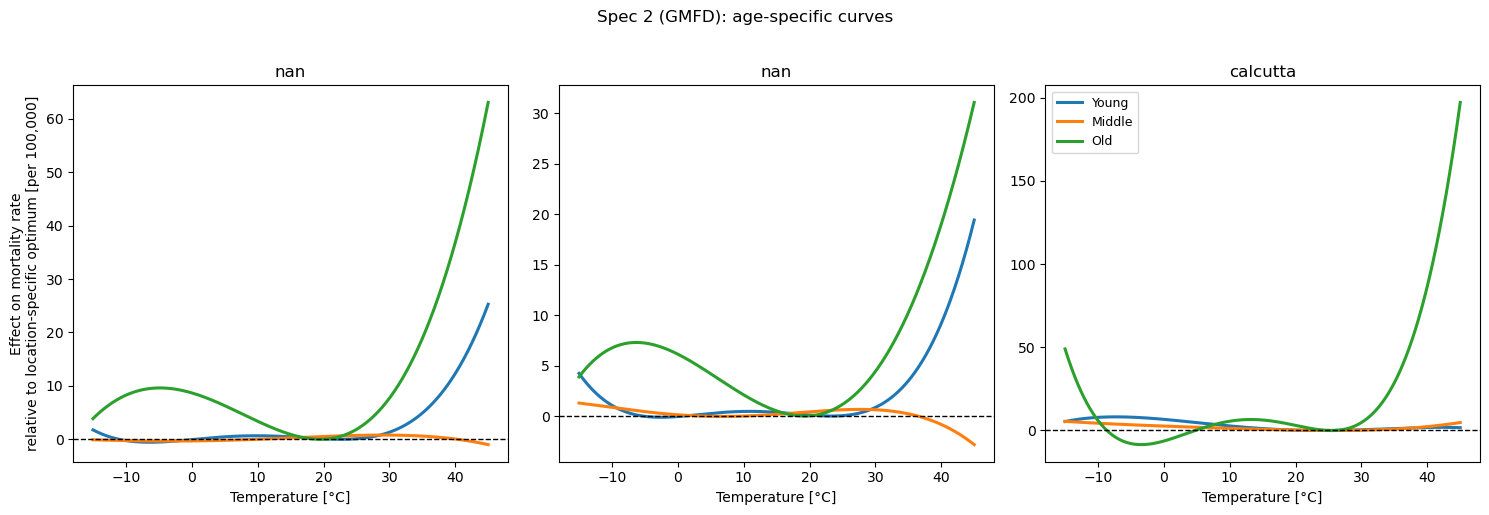

In [22]:
plot_age_curves_for_product_no_kde("GMFD", cov_dict)

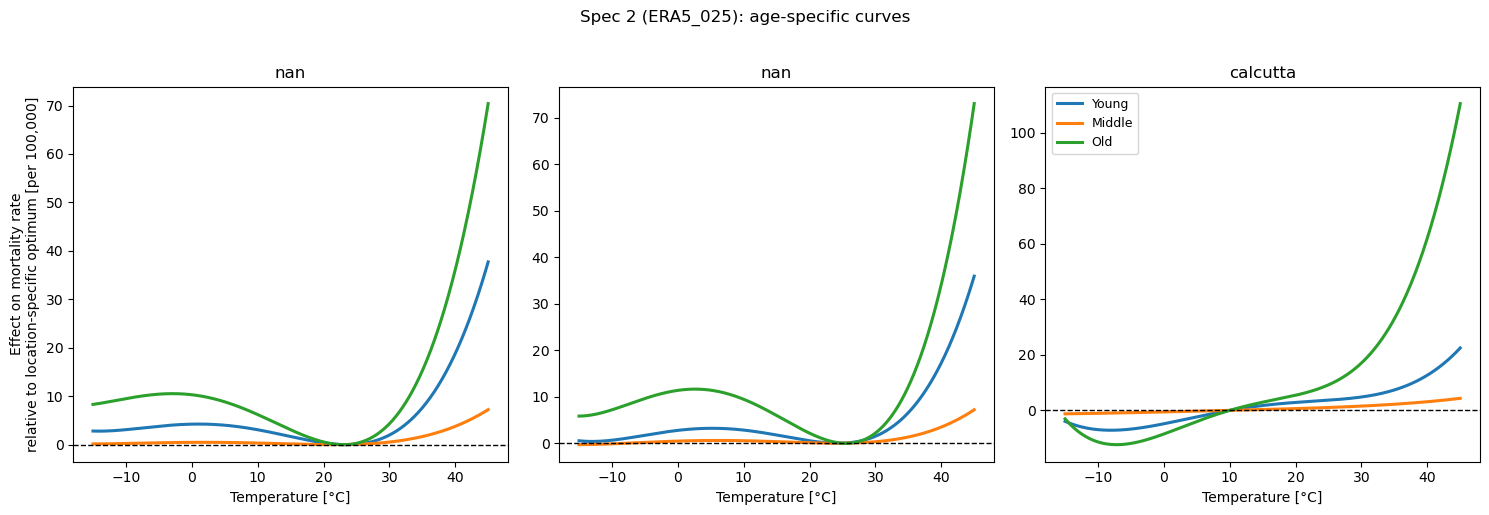

In [23]:
plot_age_curves_for_product_no_kde("ERA5_025", cov_dict)

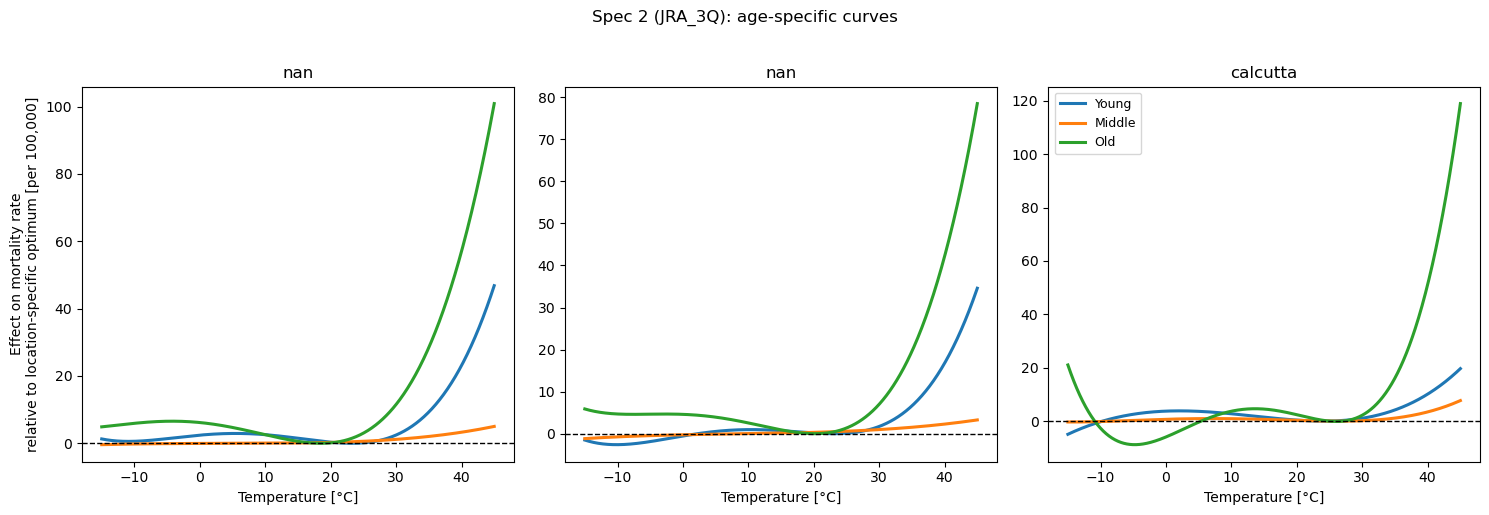

In [24]:
plot_age_curves_for_product_no_kde("JRA_3Q", cov_dict)

In [30]:
import numpy as np, pandas as pd, xarray as xr
from functools import lru_cache
from scipy.stats import gaussian_kde

CAR_PATHS_CSV = "/user/ab5405/summeraliaclimate/code/regressions/0_generate_obs_data/car_paths.csv"

# build the csvv path here and call your existing reader

# --- required globals used by your function ---
SPEC = "spec2"                       # default regression spec
TMIN, TMAX = -15.0, 45.0
SLICE_MIN, SLICE_MAX = 10.0, 25.0
AGE_LABELS = ["Young", "Middle", "Old"]
ALLOWED_PRODUCTS = {"MERRA2", "ERA5_025", "GMFD", "JRA_3Q"}


@lru_cache(None)
def _open_tas(product: str) -> xr.Dataset:
    paths = pd.read_csv(CAR_PATHS_CSV, dtype=str)
    key = product.replace("_","-").upper()
    row = paths.loc[paths["product"].str.upper()==key].iloc[0]
    fp = row["tas_filepath"]
    ds = xr.open_zarr(fp,consolidated=False) if fp.endswith(".zarr") else xr.open_dataset(fp)
    
    # normalize coords and lon domain
    if "latitude" in ds.coords:  ds = ds.rename({"latitude": "lat"})
    if "longitude" in ds.coords: ds = ds.rename({"longitude": "lon"})
    lon = ds["lon"].values
    if lon.min() >= 0 and lon.max() > 180:
        ds = ds.assign_coords(lon=(("lon", ((lon + 180) % 360) - 180))).sortby("lon")
    if np.any(np.diff(ds["lat"].values) < 0): ds = ds.sortby("lat")
    return ds

def kde_density_for_city_K(city: dict, Tgrid_C: np.ndarray, product: str, bw="scott"):
    """
    KDE of historical tas in **Kelvin** at the native grid cell nearest to
    (city['lat'], city['lon']).  Returns density evaluated at the Kelvin
    equivalents of the provided Celsius grid (Tgrid_C + 273.15).
    """
    if "lat" not in city or "lon" not in city:
        raise KeyError("city must include 'lat' and 'lon' for KDE.")

    ds   = _open_tas(product)
    lat0 = float(city["lat"])
    lon0 = ((float(city["lon"]) + 180) % 360) - 180  # match [-180,180]

    ilat = int(np.argmin(np.abs(ds["lat"].values - lat0)))
    ilon = int(np.argmin(np.abs(ds["lon"].values - lon0)))

    # Pull full time series at that grid cell (assumed Kelvin)
    temps_K = ds["tas"].isel(lat=ilat, lon=ilon).load().values.astype(float)
    temps_K = temps_K[np.isfinite(temps_K)]
    if temps_K.size == 0:
        return np.zeros_like(Tgrid_C)

    # Fit KDE in Kelvin, evaluate at Kelvin grid
    kde = gaussian_kde(temps_K, bw_method=bw)
    dens = kde(Tgrid_C + 273.15)   # evaluate at Kelvin equivalents of your °C x-axis
    return dens

def _city_title(key: str, city: dict) -> str:
    # Force the labels you want; fall back to anything the dict has
    forced = {
        "london":  "London",
        "geneva":  "Geneva",
        "calcutta":"Kolkata",
        "kolkata": "Kolkata",
    }
    if key.lower() in forced:
        return forced[key.lower()]
    return (city.get("pretty")
            or city.get("name")
            or f"{city.get('adm2_id','')} ({city.get('adm1_id','')})")


def plot_age_curves_with_density(
    product: str,
    cov_dict: dict,
    spec: str = SPEC,
    tmin: float = TMIN,
    tmax: float = TMAX,
    slice_min: float = SLICE_MIN,
    slice_max: float = SLICE_MAX,
    density_mode: str = "twinx",     # "twinx" or "shade"
    density_alpha: float = 0.25,
    show_quantiles: bool = True,     # draw 5th/95th percentile lines from density
    baseline_band: bool = True       # shade the 10–25°C normalization window
):
    if product not in ALLOWED_PRODUCTS:
        raise ValueError(f"product must be one of {sorted(ALLOWED_PRODUCTS)}")

    csvv_path = CSVV_DIR / f"agespec_interaction_response_{spec}_{product.replace('-','_')}.csvv"
    gamma = read_gamma_from_csvv(csvv_path)  # <- your current reader that takes a Path


    cities = list(cov_dict.keys())
    n = len(cities)
    T = np.linspace(tmin, tmax, 800)

    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharey=False)
    if n == 1:
        axes = [axes]

    for ax, key in zip(axes, cities):
        city = cov_dict[key]
        # REPLACE your current `name = ...` with:
        name = _city_title(key, city)


        if baseline_band:
            ax.axvspan(slice_min, slice_max, color="0.9", alpha=0.25, zorder=0)

        # Curves for each age, normalized by the min in [slice_min, slice_max]
        for a in range(3):
            b = coeffs_for_city(gamma[a, :, :],
                                lr_tavg=float(city["lr_tavg"]),
                                loggdppc=float(city["loggdppc"]))
            y_raw = quartic_no_const(T, b)
            mask = (T >= slice_min) & (T <= slice_max)
            base = y_raw[mask].min() if mask.any() else y_raw.min()
            y = y_raw - base
            line, = ax.plot(T, y, lw=2.2, label=AGE_LABELS[a], zorder=3)

            # mark the slice-min point (for the mean curve)
            base_T = T[mask][np.argmin(y_raw[mask])] if mask.any() else T[np.argmin(y_raw)]
            ax.scatter([base_T], [0.0], s=20, color=line.get_color(), zorder=5)

        dens = None
        try:
            dens = kde_density_for_city_K(city, T, product, bw="scott")
        except Exception as e:
            print(f"[KDE skipped for {name}] {e}")
        
        if dens is not None and np.any(np.isfinite(dens)) and np.nanmax(dens) > 0:
            ax2 = ax.twinx()
            ax2.fill_between(T, 0, dens, color="0.7", alpha=0.25, zorder=0)
            ax2.set_yticks([])
            ax2.set_ylabel("Temp density (KDE)", color="0.5")

        ax.axhline(0, ls="--", color="k", lw=1, zorder=1)
        ax.set_xlim(tmin, tmax)
        ax.set_title(name)
        ax.set_xlabel("Temperature [°C]")
        ax.grid(False)

    axes[0].set_ylabel("Effect on mortality rate\nrelative to min over 10–25°C [per 100,000]")
    axes[-1].legend(frameon=True, fontsize=9, loc="upper left")
    fig.suptitle(f"Spec 2 ({product}): age-specific curves + temperature density", y=1.02)
    plt.tight_layout()
    plt.show()



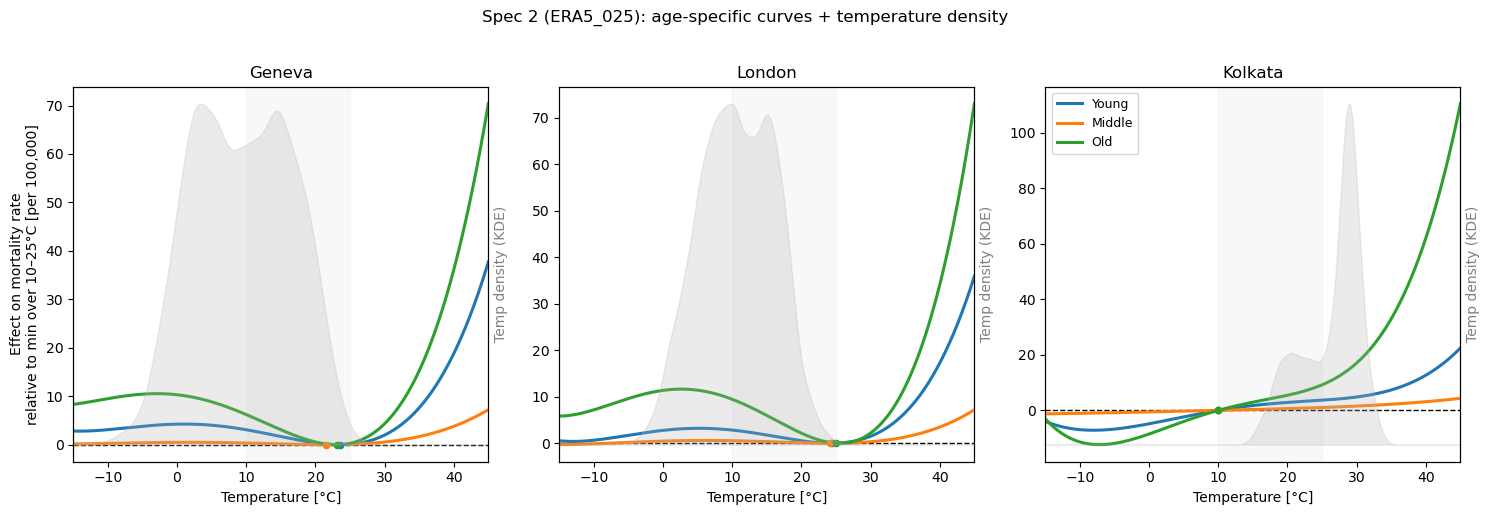

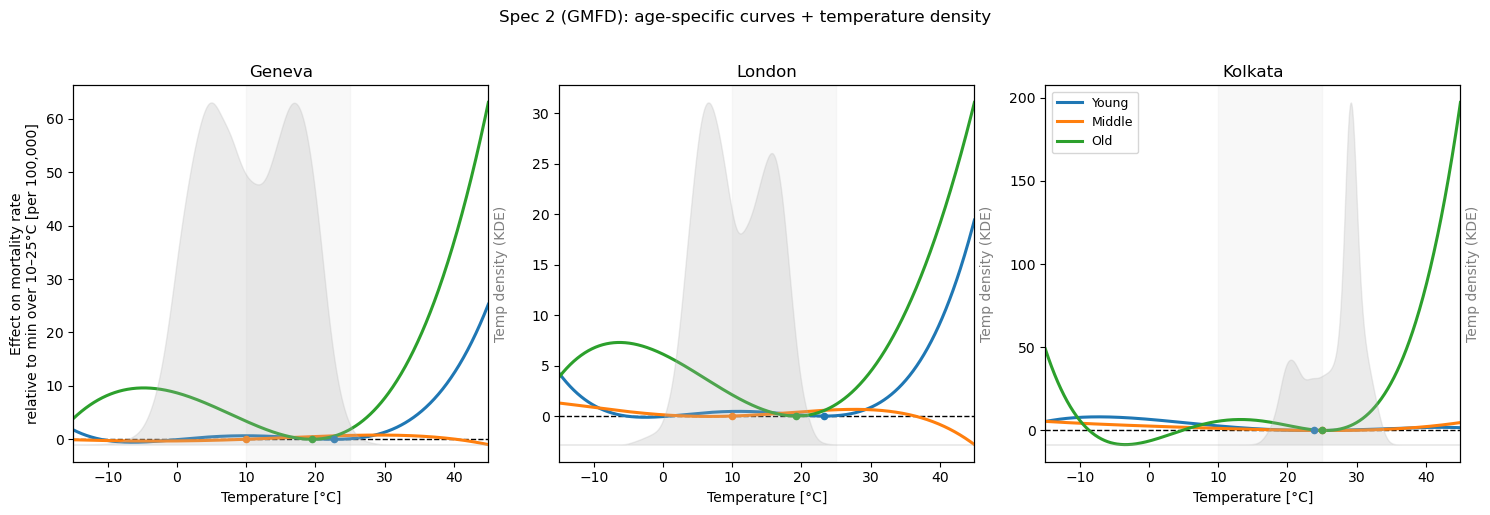

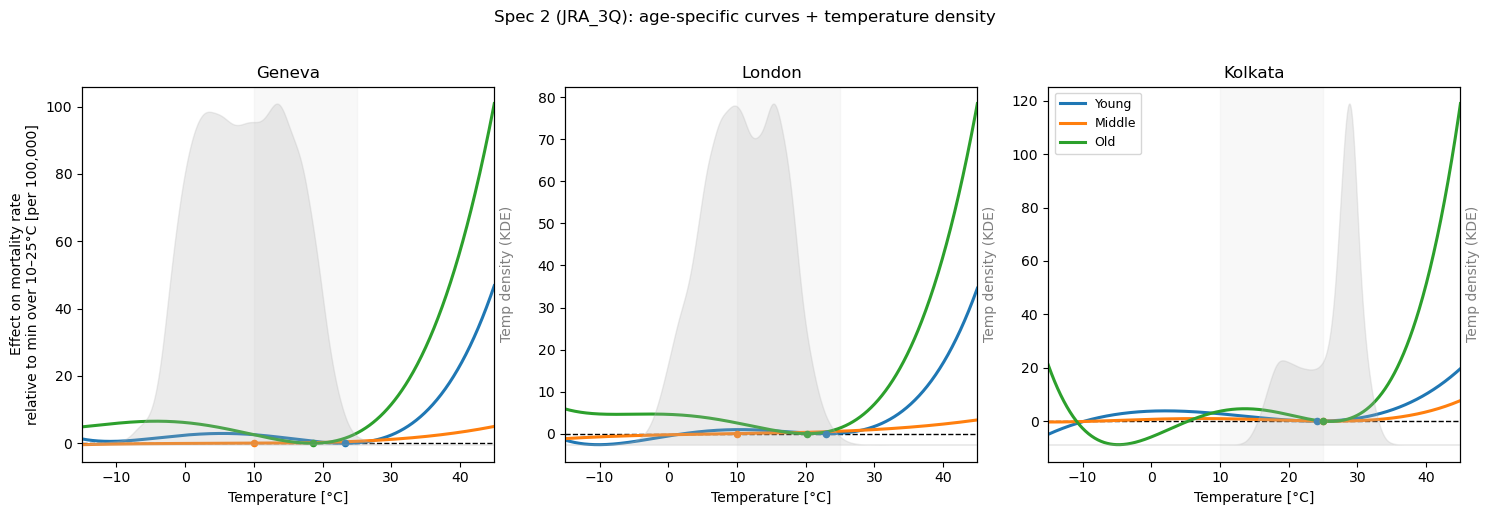

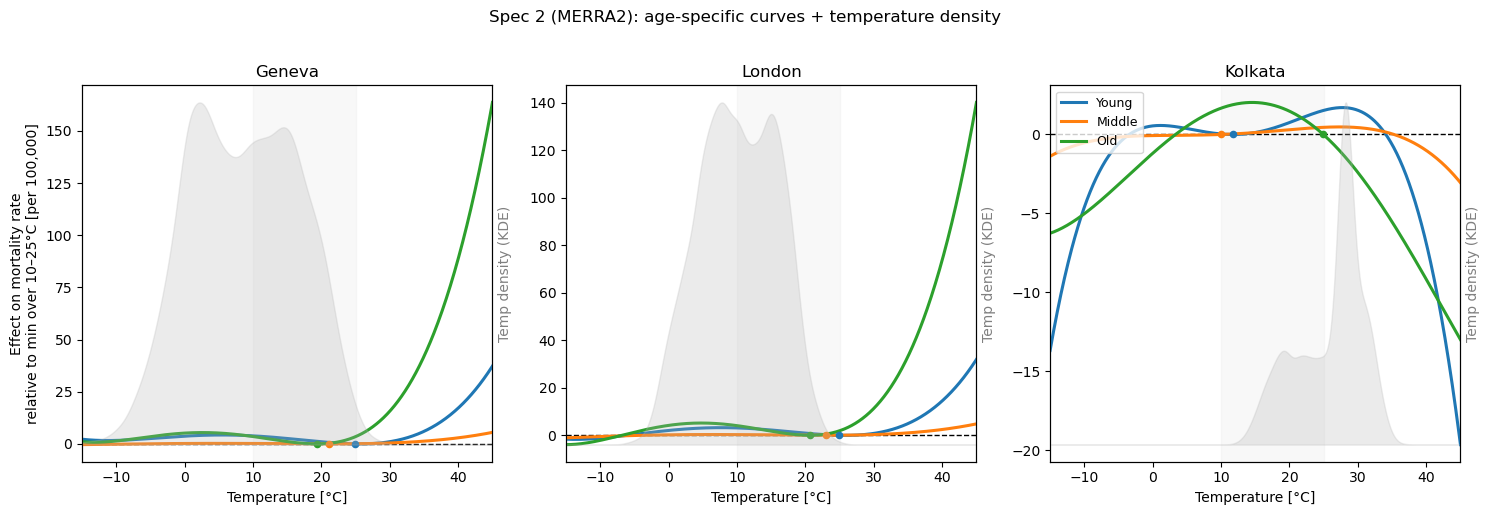

In [32]:

from pathlib import Path
CSVV_DIR = Path("/user/ab5405/summeraliaclimate/code/regressions/output/age_spec_interacted_csvv")

plot_age_curves_with_density(
    "ERA5_025", cov_dict,
    density_mode="twinx",   # or "shade"
    density_alpha=0.25,
    show_quantiles=True,
    baseline_band=True
)

plot_age_curves_with_density("GMFD",     cov_dict)# GMFD
plot_age_curves_with_density("JRA_3Q",   cov_dict)# JRA_3Q
plot_age_curves_with_density("MERRA2",   cov_dict)# MERRA2